# Lesson 8: More Decisions

## Intro to Quantified Cognition

By: Per B. Sederberg, PhD


<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2020_Spring/notebooks/08_More_Decisions.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>



## Lesson plan

- Linear Ballistic Accumulator exploration
- PDA explantion
- Model fits to data
- Model comparison


## *ONLY* if on Google Colab

In [ ]:
# to install RunDEMC (you'll want to upgrade if local, too)
!pip install --upgrade git+https://github.com/compmem/RunDEMC.git
!pip install fastprogress

In [ ]:
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/2021_Spring/notebooks/decision_data.csv

In [ ]:
# to install more libraries
#!pip install plotnine
!pip install KDEpy
!pip install arviz

## Load modules

In [2]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats
import arviz as az

from ipywidgets import interact, fixed

#from RunDEMC.density import kdensity
from KDEpy import FFTKDE

## Load and process the data

In [19]:
# load in the data
dat = pd.read_csv('decision_data.csv', index_col=0)

# get rid of the neutral condition
dat = dat[dat.cond != 'Neutral']

# make a new column that combines accuracy and rt
dat['rt_acc'] = dat['rt']
dat.loc[dat.correct==0,'rt_acc'] = -dat['rt']
dat.head()

,correct,rt,cond,log_rt,rt_acc
3,1,0.4784,Accuracy,-0.737308,0.4784
4,1,0.4300,Accuracy,-0.843970,0.4300
5,1,0.4486,Accuracy,-0.801624,0.4486
6,1,0.3991,Speed,-0.918543,0.3991
8,1,0.4393,Accuracy,-0.822573,0.4393


In [20]:
dat.groupby(['cond', 'correct'])['rt'].mean().reset_index()


,cond,correct,rt
0,Accuracy,0,0.589848
1,Accuracy,1,0.603819
2,Speed,0,0.349665
3,Speed,1,0.379169


## What does this tell us?

- Looking at behavioral effects alone can not reveal the processes that gave rise to that choice and RT.

- i.e., if you made a specific response, we don't know *why* you made that response.

## Going Deeper: What affects your decisions? 


## Linear Ballistic Accumlator (LBA)

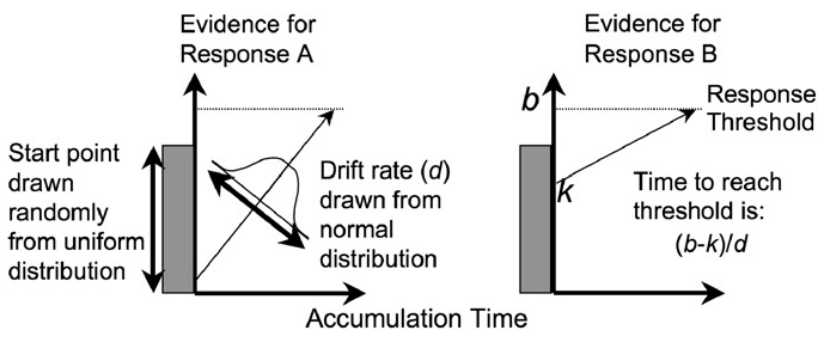

In [5]:
def lba_sim(I=(1.0,1.5), A=.1, S=1.0, b=1.0, num_sims=1000,
            max_time=2., t0=0.0, **kwargs):
    # set drift rate from inputs
    dr = np.squeeze(np.atleast_1d(I))
    
    # set the number of choices
    nc = len(dr)
    
    # pick starting points
    k = np.random.uniform(0.,A,(num_sims,nc))
    
    # pick drifts
    # must make sure at least one d is greater than zero for each sim
    d = np.random.normal(dr,S,(num_sims,nc))
    # see where there are none above zero
    ind = np.all(d<=0.0,axis=1)
    while np.any(ind):
        d[ind,:] = np.random.normal(dr,S,(ind.sum(),nc))
        ind = np.all(d<=0.0,axis=1)

    # clip it to avoid divide by zeros
    d[d<=0.0] = np.finfo(dr.dtype).eps

    # calc the times for each
    t = (b-k)/d

    # see the earliest for each resp
    inds = t.argmin(1)
    times = t.take(inds+np.arange(t.shape[0])*t.shape[1])

    # process into choices
    times += t0

    # get valid responses
    resp_ind = times < (max_time)
    inds[~resp_ind] = -1
    times[~resp_ind] = -1
    
    # make a dataframe
    return pd.DataFrame({'correct': inds, 'rt': times})
    


In [63]:
# set up the sim
nsims = 5000
cond='Accuracy'
ndat = (dat['cond']==cond).sum()
plt.figure(figsize=(10,6))

# normed histogram
def dhist(dat, nsims, alpha=.3, color='b'):
    p,b = np.histogram(dat,bins='auto',density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nsims
    return plt.bar(b[1:]-w,p,width=w,alpha=.3,color=color)

# normed pdf
xvals = np.linspace(0.1,2.0,100)
def dplot(dat, nsims, color='b', lw=2.):
    #p,xx = kdensity(dat, extrema=(xvals.min(),xvals.max()), xx=xvals)
    p = FFTKDE(kernel='epa', bw='silverman').fit(dat).evaluate(xvals)
    p *= float(len(dat))/nsims
    plt.plot(xvals, p, color=color, lw=2.)

# put it all together
@interact(d1=(0.0,5.0,0.05),
          d2=(0.0,5.0,0.05),
          A=(0.0,1.0,.05),
          b=(0.0,5.0,.05),
          t0=(0.0,1.0,.02),
          S=fixed(1.0)
          )
def run_lba(d1=1.0, d2=2.0, A=.1, b=1.0, t0=0.0, S=1.0):
    # run the LBA model
    res = lba_sim(I=(d1, d2), A=A, S=S, b=b, num_sims=nsims, max_time=2.0, t0=t0)
    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
    dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
    dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
    #ylim(0,5.0)
    plt.xlim(0,2.0)

<Figure size 720x432 with 0 Axes>

interactive(children=(FloatSlider(value=1.0, description='d1', max=5.0, step=0.05), FloatSlider(value=2.0, des…

## Using computers to test hypotheses

In [32]:
from RunDEMC import Model, Param, dists, DE
from RunDEMC.pda import PDA
from RunDEMC.io import arviz_dict
from RunDEMC.density import boxcox

## Fitting Decision Models

What do we do when our model doesn't have an analytical likelihood function?

PDA to the rescue!!!

## Probability Density Approximation

Applies a kernel density estimate (KDE) to simulated data.

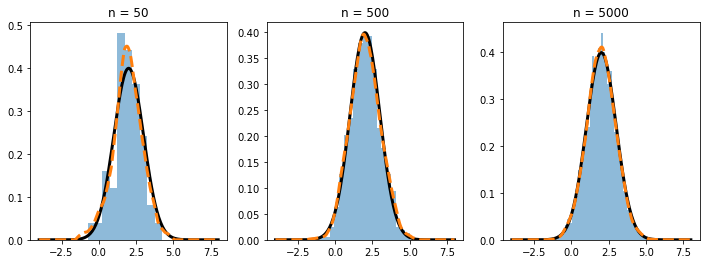

In [57]:
# generate some data from a known distribution
true_mean = 2.0
true_std = 1.0
dist = dists.normal(mean=true_mean, std=true_std)
rdat = dist.rvs(5000)

# define range for plots
xrng = np.linspace(-4,8.0,200)

# plot different amounts of data with a kernel density estimate
plt.figure(figsize=(12, 4))
for i, n in enumerate([50, 500, 5000]):
    # pick the subplot
    plt.subplot(1, 3, i+1)
    
    # plot the actual data
    plt.hist(rdat[:n], bins='auto', density=True, alpha=0.5);
    
    # plot the true PDF
    plt.plot(xrng, dist.pdf(xrng), 'k', lw=3)
    
    # plot the kde
    p = FFTKDE(kernel='epa', bw='silverman').fit(rdat[:n]).evaluate(xrng)
    plt.plot(xrng, p, '--', lw=3)
    
    # give title
    plt.title('n = %d' % n)


## RunDEMC setup

In [83]:
# Test change in threshold

# set up the params
min_rt = dat.rt.min()
params = [Param(name='d1', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='A', prior=dists.trunc_normal(.5, 2.0, 0., 2.0)),
          Param(name='b_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='b_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.normal(0.0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]

# set up PDA
rt_min = .05
rt_max = 2.1
pda = PDA(dat.to_records(), cat_var='correct', 
          cont_var='log_rt', cond_var='cond', 
          lower=np.log(rt_min), upper=np.log(rt_max))
print('Lower:', pda._lower, '\nUpper:', pda._upper)

# define the likelihood function
nsims = 10000
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first check for simple issues
        if (p['A'] > p['b_A']) or (p['A'] > p['b_S']) or \
            np.any(np.array(p.tolist())<0):
            # A can't be bigger than b
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        # run the simulation
        resA = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=1.0, b=p['b_A'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        
        # add the cond
        resA['cond'] = 'Accuracy'
        
        # then Speed
        resS = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=1.0, b=p['b_S'], 
                       num_sims=nsims, max_time=2.0, t0=p['t0'])   
        
        # add the cond
        resS['cond'] = 'Speed'  
        
        # combine into one dataframe
        res = pd.concat([resA, resS], ignore_index=True)
        
        # convert fast responses to non-responses
        res.loc[res.rt < rt_min, 'correct'] = -1
        
        # add log_rt column
        res['log_rt'] = 0.0
        res.loc[res.rt > 0.0, 'log_rt'] = np.log(res.loc[res.rt > 0.0, 'rt'])
        
        # calc log like via PDA
        likes[i] += pda.calc_log_like(res.to_records())
        if likes[i] == -np.inf:
            continue
        
    return likes
        
    
# set up DE
prop_gen = DE(gamma=(.2, 1.0), gamma_best=0.0, rand_base=False)
burnin_prop_gen = DE(gamma=(.2, 1.0), gamma_best=None, rand_base=True)

# make the model
m = Model('decisions', params=params,
          like_fun=like_fun,
          #like_args=(dat,),
          purify_every=5,
          pop_parallel=True,
          proposal_gen=prop_gen,
          burnin_proposal_gen=burnin_prop_gen,
          verbose=True)


Lower: -2.995732273553991 
Upper: 0.7419373447293773


In [84]:
# do some burnin
times = m.sample(100, burnin=True)
times = m.sample(500, burnin=False)


Initializing: 60(60) 20(20) 10(10) 5(5) 3(3) Iterations (100):


Iterations (500):


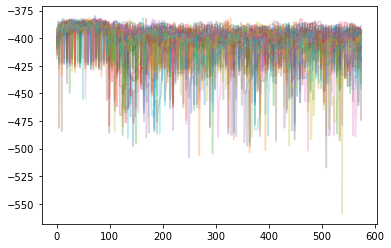

In [85]:
plt.plot(m.weights[25:], alpha=.3);

In [86]:
print("Best fitting params:")
burnin=200
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights.ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: -393.9869945047253
"d1": 1.747543,
"d2": 2.743220,
"A": 0.402478,
"b_A": 1.445420,
"b_S": 0.827437,
"t0": 0.140035,


In [87]:
# save out model to an ArviZ Inference Dataset
daz_t = az.from_dict(**arviz_dict(m, burnin=200))
daz_t.posterior

<xarray.Dataset>
Dimensions:  (chain: 60, draw: 401)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
Data variables:
    d1       (chain, draw) float64 1.834 1.834 1.834 2.115 ... 1.84 1.84 1.632
    d2       (chain, draw) float64 2.721 2.721 2.721 3.052 ... 2.784 2.784 2.525
    A        (chain, draw) float64 0.3265 0.3265 0.3265 ... 0.7006 0.7006 0.5563
    b_A      (chain, draw) float64 1.485 1.485 1.485 1.701 ... 1.467 1.467 1.291
    b_S      (chain, draw) float64 0.8943 0.8943 0.8943 ... 0.8986 0.8986 0.7478
    t0       (chain, draw) float64 0.1122 0.1122 0.1122 ... 0.1857 0.1857 0.1847
Attributes:
    created_at:     2021-03-25T17:32:44.347468
    arviz_version:  0.10.0

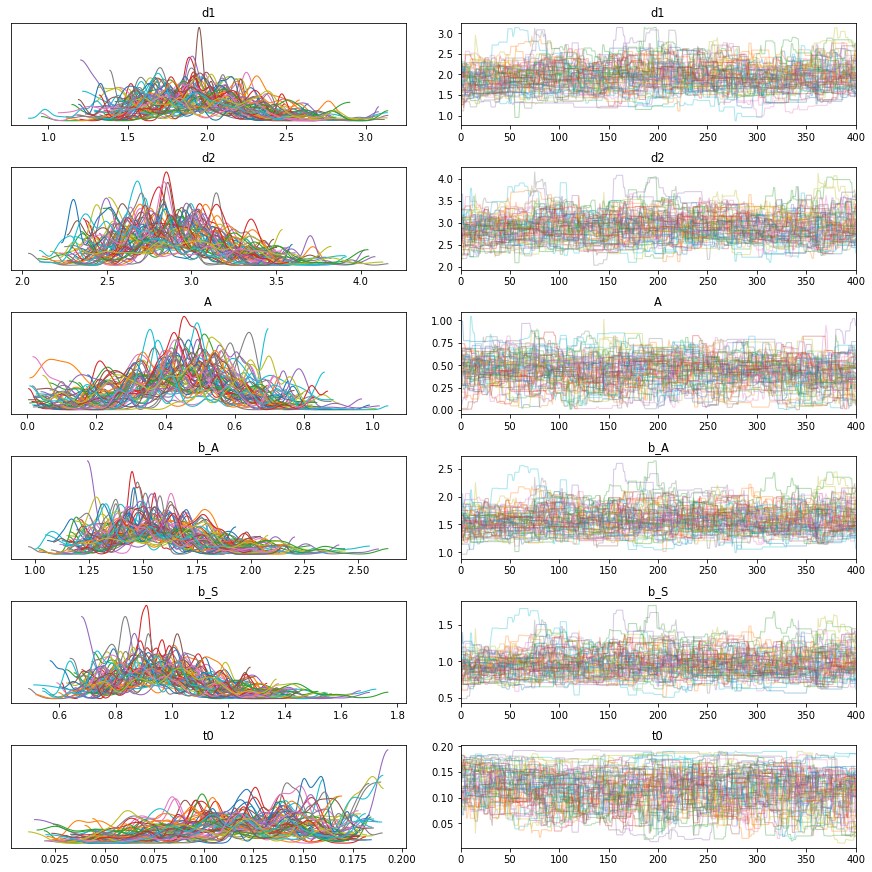

In [88]:
az.plot_trace(daz_t);

In [89]:
az.summary(daz_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
d1,1.933,0.333,1.306,2.542,0.022,0.015,239.0,239.0,233.0,267.0,1.19
d2,2.895,0.310,2.322,3.451,0.018,0.013,298.0,298.0,296.0,646.0,1.14
A,0.440,0.167,0.079,0.725,0.010,0.007,272.0,272.0,274.0,469.0,1.16
b_A,1.576,0.233,1.171,2.008,0.014,0.010,288.0,288.0,288.0,572.0,1.15
b_S,0.967,0.178,0.652,1.300,0.010,0.007,309.0,309.0,310.0,616.0,1.14
t0,0.119,0.037,0.059,0.191,0.003,0.002,197.0,177.0,182.0,175.0,1.24


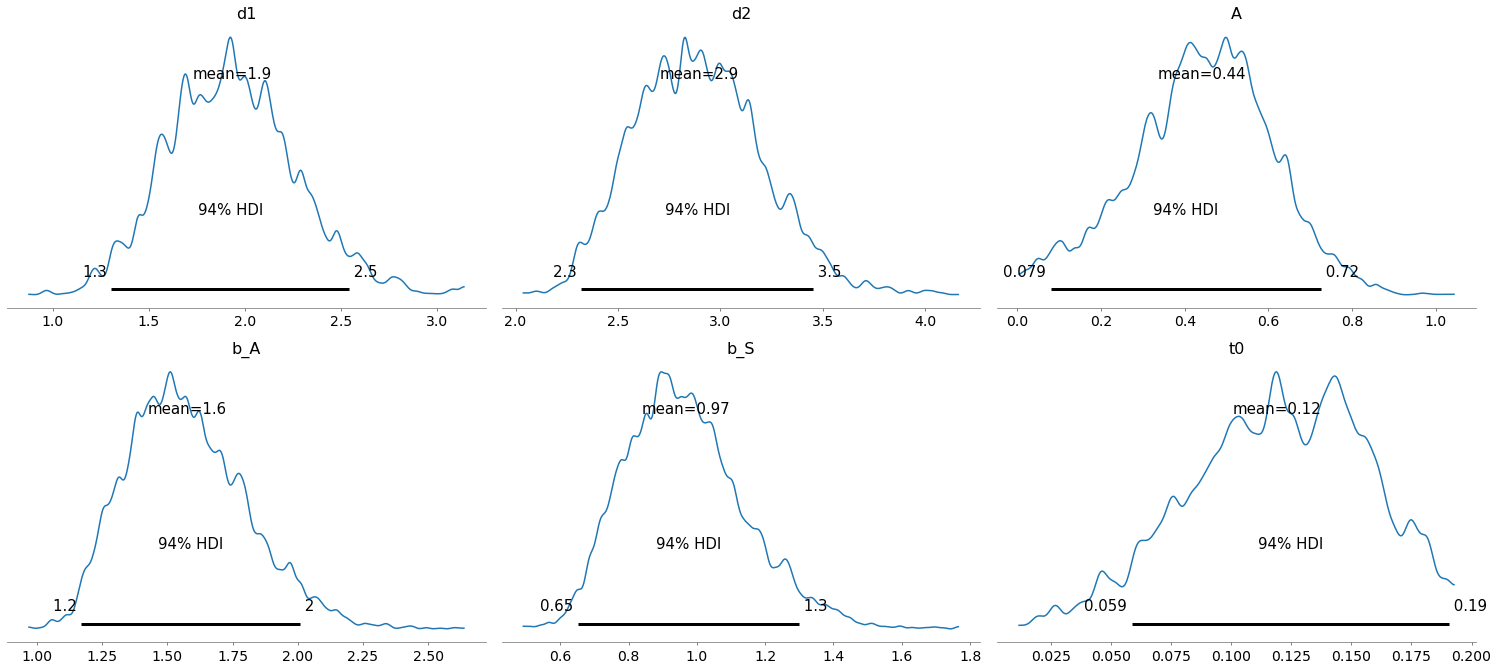

In [90]:
az.plot_posterior(daz_t);

/home/per/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


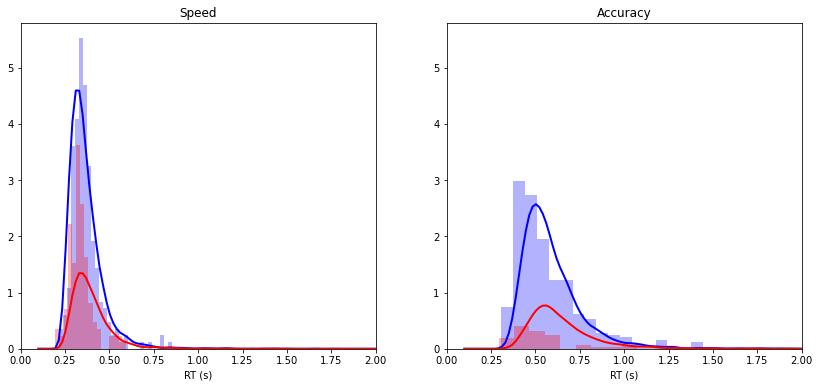

In [91]:
# Run sim with best fitting params
plt.figure(figsize=(14,6))
fig = plt.gcf()
ax1 = fig.add_subplot(121)

cond = 'Speed'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax = plt.subplot(1,2,1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

cond = 'Accuracy'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax2 = fig.add_subplot(122, sharey=ax1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);

In [94]:
# Test change in drift rate

# set up the params
params = [Param(name='d1_A', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2_A', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d1_S', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2_S', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='A', prior=dists.trunc_normal(.5, 2.0, 0., 2.0)),
          Param(name='b', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.normal(0.0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]


# set up PDA
rt_min = .05
rt_max = 2.1
pda = PDA(dat.to_records(), cat_var='correct', 
          cont_var='log_rt', cond_var='cond', 
          lower=np.log(rt_min), upper=np.log(rt_max))
print('Lower:', pda._lower, '\nUpper:', pda._upper)

# set up the likelihood function
nsims = 10000
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        if (p['A'] > p['b']) or \
            np.any(np.array(p.tolist())<0):
            # A can't be bigger than b
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        # run the simulation
        resA = lba_sim(I=(p['d1_A'], p['d2_A']), A=p['A'], S=1.0, b=p['b'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        
        # add the cond
        resA['cond'] = 'Accuracy'
        
        # then Speed
        resS = lba_sim(I=(p['d1_S'], p['d2_S']), A=p['A'], S=1.0, b=p['b'], 
                       num_sims=nsims, max_time=2.0, t0=p['t0'])   
        
        # add the cond
        resS['cond'] = 'Speed'  
        
        # combine into one dataframe
        res = pd.concat([resA, resS], ignore_index=True)
        
        # convert fast responses to non-responses
        res.loc[res.rt < rt_min, 'correct'] = -1
        
        # add log_rt column
        res['log_rt'] = 0.0
        res.loc[res.rt > 0.0, 'log_rt'] = np.log(res.loc[res.rt > 0.0, 'rt'])
        
        # calc log like via PDA
        likes[i] += pda.calc_log_like(res.to_records())
        if likes[i] == -np.inf:
            continue        
        
    return likes
        
# make the model
m = Model('decisions2', params=params,
          like_fun=like_fun,
          #like_args=(dat,),
          pop_parallel=True,
          purify_every=5,
          verbose=True)


Lower: -2.995732273553991 
Upper: 0.7419373447293773


In [95]:
# do some burnin
times = m.sample(100, burnin=True)
times = m.sample(500, burnin=False)


Initializing: 70(70) 18(18) 3(3) 1(1) Iterations (100):


Iterations (500):


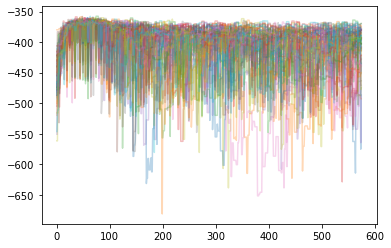

In [96]:
plt.plot(m.weights[25:], alpha=.3);

In [97]:
print("Best fitting params:")
burnin=5
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights.ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: -363.19995831301713
"d1_A": 1.477922,
"d2_A": 2.894297,
"d1_S": 4.060600,
"d2_S": 4.355786,
"A": 0.459059,
"b": 1.810963,
"t0": 0.031220,


/home/per/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


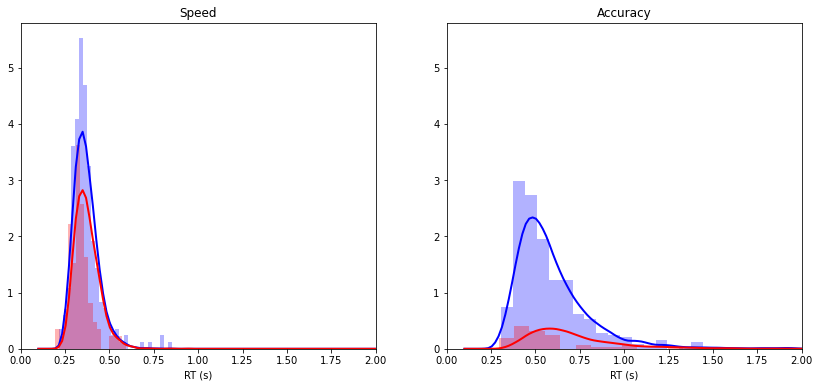

In [98]:
# Run sim with best fitting params
plt.figure(figsize=(14,6))
fig = plt.gcf()
ax1 = fig.add_subplot(121)

cond = 'Speed'

# run the LBA model
res = lba_sim(I=(pp['d1_'+cond[0]], pp['d2_'+cond[0]]), A=pp['A'], S=1.0, b=pp['b'], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax = plt.subplot(1,2,1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

cond = 'Accuracy'

# run the LBA model
res = lba_sim(I=(pp['d1_'+cond[0]], pp['d2_'+cond[0]]), A=pp['A'], S=1.0, b=pp['b'], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax2 = fig.add_subplot(122, sharey=ax1)
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==1)]['rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==0)]['rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);

In [99]:
# save out model to an ArviZ Inference Dataset
daz_d = az.from_dict(**arviz_dict(m, burnin=200))
daz_d.posterior

<xarray.Dataset>
Dimensions:  (chain: 70, draw: 401)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 60 61 62 63 64 65 66 67 68 69
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
Data variables:
    d1_A     (chain, draw) float64 1.428 1.428 1.428 1.428 ... 1.598 1.598 1.598
    d2_A     (chain, draw) float64 2.909 2.909 2.909 2.909 ... 2.699 2.699 2.699
    d1_S     (chain, draw) float64 3.698 3.698 3.698 3.698 ... 3.973 3.973 3.973
    d2_S     (chain, draw) float64 4.563 4.563 4.563 4.563 ... 4.068 4.068 4.068
    A        (chain, draw) float64 0.3664 0.3664 0.3664 ... 0.7957 0.7957 0.7957
    b        (chain, draw) float64 1.786 1.786 1.786 1.786 ... 1.885 1.885 1.885
    t0       (chain, draw) float64 0.01726 0.01726 0.01726 ... 0.05615 0.05615
Attributes:
    created_at:     2021-03-25T17:51:42.217395
    arviz_version:  0.10.0

In [103]:
# do a model comparison
az.compare({'threshold': daz_t, 'drift': daz_d}, ic='waic')

/home/per/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/home/per/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/home/per/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1444: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  """
/home/per/anaconda3/lib/

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
threshold,0,-532.807621,143.326781,0.0,NaN,0.0,0.0,True,log
drift,1,-1440.151452,1070.364062,907.343831,0.0,0.0,0.0,True,log


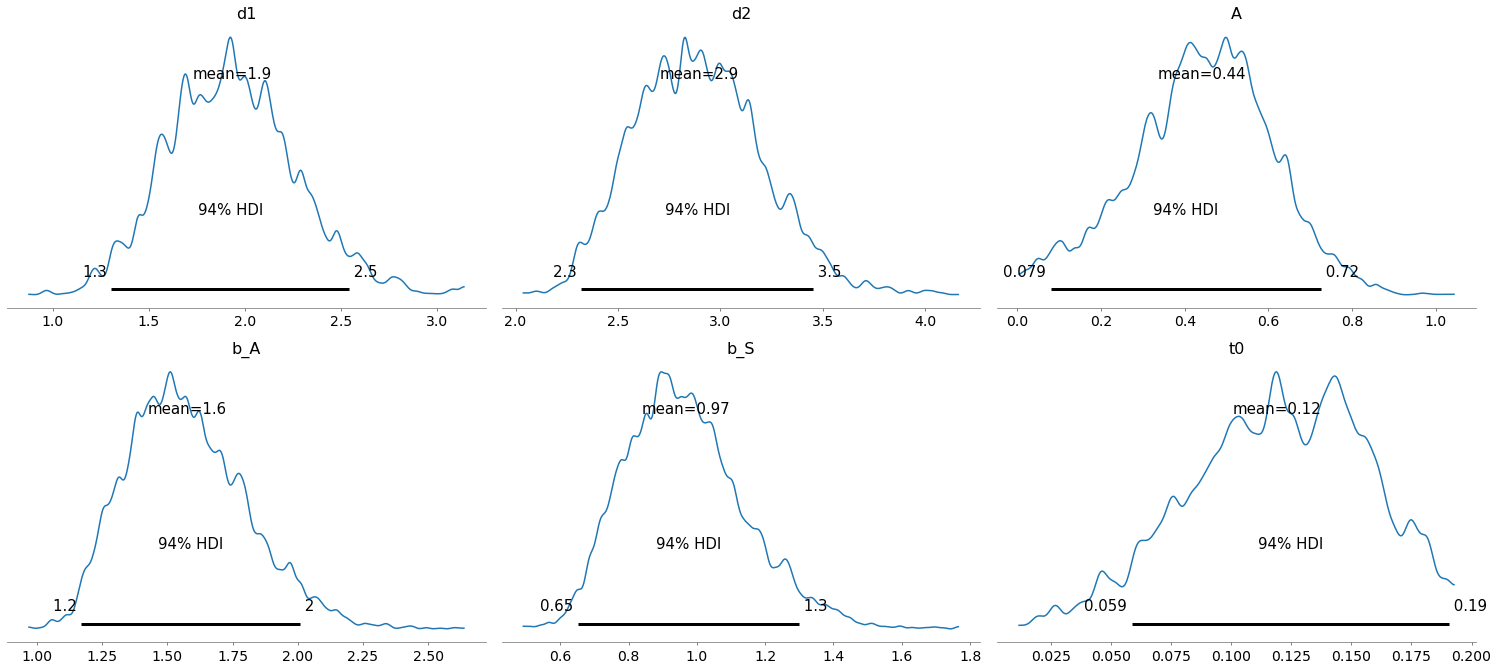

In [101]:
az.plot_posterior(daz_t);

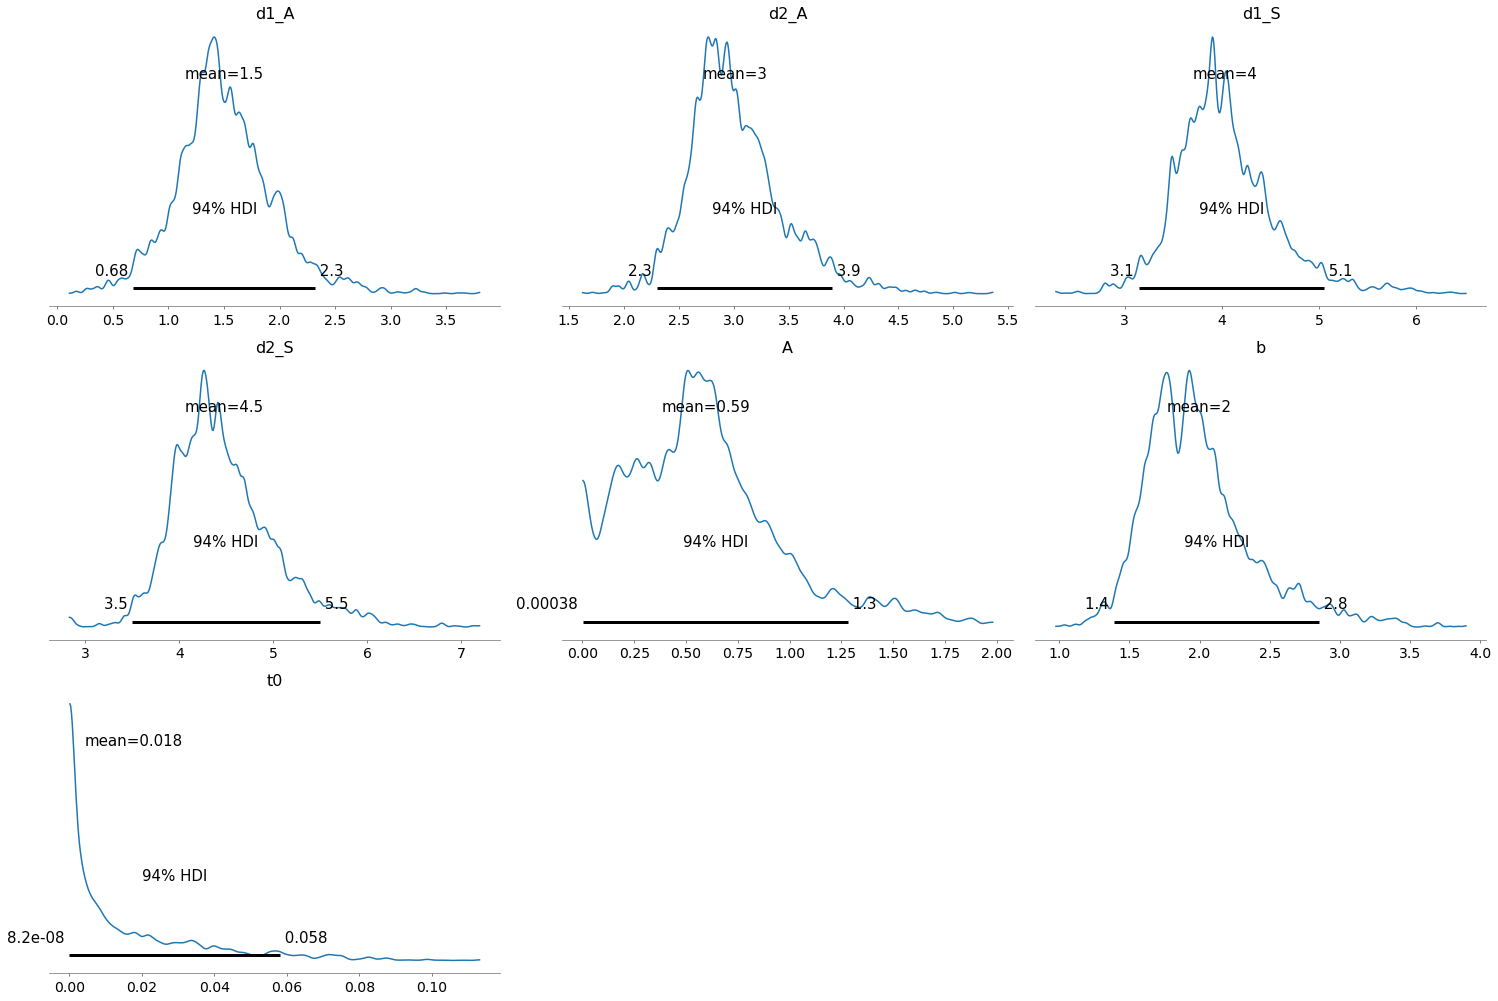

In [102]:
az.plot_posterior(daz_d);